### Laboratorio 6 - Generative Adversarial Network
Stefano Aragoni, Carol Arévalo

-----------

En esta práctica se diseñó una Generative Adversarial Network (GAN) con el propósito de poder generar imágenes artificiales que imiten la distribución de los datos originales Para esto, fue necesario diseñar una red neuronal que fuera capaz de generar imágenes, y otra red neuronal que fuera capaz de diferenciar entre imágenes reales y generadas. 

A continuación se muestra el código utilizado para la creación de la GAN, así como los resultados obtenidos.

------- 

##### Importar librerías

Como primer paso, se importaron las librerías necesarias para la creación de la GAN.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten, Input
import tensorflow as tf
from keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam
import os
import cv2
from tqdm import tqdm 
import pickle
from keras.preprocessing.image import ImageDataGenerator
import sys

2023-10-02 20:07:58.061116: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


--------
### **Preparación de Datos**

##### Cargar el dataset de CelebA y Preprocesamiento de Datos 

Para iniciar, se descargó el dataset de CelebA. Este conjunto de datos consta de más de 200,000 imágenes a color, de 128 X 128 X 3 c/u. A continuación se muestra la ubicación de las imágenes en el dataset.

In [2]:
# Direcciones de los archivos
fotos_dir = 'archive/img_align_celeba/'
fotos_dir_class = 'archive/img_align_celeba/img_align_celeba/'

# Cantidad de fotos en el directorio
n_fotos = len(os.listdir(fotos_dir_class))
print(n_fotos, "fotos en el directorio")

202599 fotos en el directorio


A través de la librería de Keras, se cargaron las imágenes por batches.

Asimismo, se les aplicó un preprocesamiento, el cual consistió en normalizar los valores de los pixeles de las imágenes, recortarlas y redimensionarlas a 64 X 64 X 3.

In [3]:
# Batch size
batch_size = 75000

# Tamaño de las imágenes
img_size = 64

In [4]:
# Leer las imagenes -> Función recomendada por Prof. Luis Furlan.

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,                    # PRE-PROCESAMIENTO: Normalizar los valores de los pixeles
    horizontal_flip=True,
)

In [5]:
# Carga las imagenes de entrenamiento

train_generator = datagen.flow_from_directory(
    fotos_dir,
    target_size=(img_size, img_size),        # PRE-PROCESAMIENTO: RECORTAR Y REDIMENSIONAR IMÁGENES
    batch_size=batch_size,
    class_mode=None,
    subset='training'
)

Found 202599 images belonging to 1 classes.


(50000, 64, 64, 3)


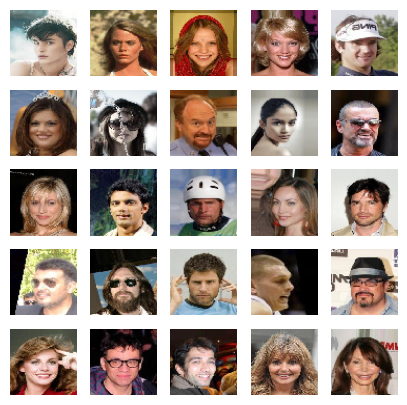

In [6]:
# Mostrar 25 imagenes de entrenamiento

X_train = train_generator[0]
print(X_train.shape)
fig, axs = plt.subplots(5, 5, figsize=(5, 5))

for i in range(5):
    for j in range(5):
        img = X_train[i * 5 + j]
        axs[i, j].imshow(img)
        axs[i, j].axis('off')

plt.show()

--------
### **Implementación de la GAN**

##### Diseño del generador y el discriminador

A continuación se demuestra el modelo del <font color=orange>generador</font>. En este caso, se utilizó una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Se encargará de generar imágenes a partir de un vector de ruido.

In [7]:
tamanio_codificacion = 100

img_shape = train_generator[0].shape[1:]
print(img_shape)

(64, 64, 3)


In [8]:
# Generador
generador = Sequential()
generador.add(Dense(8 * 8 * 256, input_shape=[tamanio_codificacion])) 
generador.add(Reshape([8, 8, 256]))
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="relu"))  
generador.add(BatchNormalization())
generador.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="sigmoid")) 

A continuación se demuestra el modelo del <font color=orange>discriminador</font>. El discriminador es una red neuronal, la cual utiliza relu y sigmoid como funciones de activación. Esta se encarga de diferenciar entre imágenes reales y generadas.

In [9]:
# Discriminador
discriminador = Sequential()
discriminador.add(Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=(64, 64, 3)))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminador.add(LeakyReLU(0.3))
discriminador.add(Dropout(0.5))
discriminador.add(Flatten())
discriminador.add(Dense(1, activation="sigmoid"))

##### Definición de funciones de pérdida y optimizadores

Con los modelos listos, se procedió a definir las funciones de pérdida y los optimizadores. Esto con el propósito de poder entrenar la GAN. Más específicamente, se utilizó la función de <font color=orange>Binary Cross Entropy</font> (BCE) como función de pérdida, y el <font color=orange>optimizador Adam</font>. 

Asimismo, se indicó que el discriminador no se entrenaría durante el entrenamiento de la GAN, ya que el objetivo es entrenar al generador para que engañe al discriminador.

In [10]:
# Compilar Discriminador
discriminador.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Generador
z = Input(shape=(tamanio_codificacion,))
img = generador(z)

# El discriminador no debe ser entrenado durante el entrenamiento del generador
discriminador.trainable = False

# Discriminador para evaluar el generador
validity = discriminador(img)

# El modelo combinado
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.002, 0.5))

--------
### **Entrenamiento de la GAN**

##### Implementación del bucle de entrenamiento

In [11]:
# Entrenamiento
epochs = 1000
batch_size = 128
half_batch = batch_size // 2

for epoch in tqdm(range(epochs)):
    
    # Entrenar el discriminador
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_imgs = X_train[idx]
    noise = np.random.normal(0, 1, (half_batch, tamanio_codificacion))
    gen_imgs = generador.predict(noise)
    real_labels = np.ones((half_batch, 1))
    fake_labels = np.zeros((half_batch, 1))
    d_loss_real = discriminador.train_on_batch(real_imgs, real_labels)
    d_loss_fake = discriminador.train_on_batch(gen_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Entrenar el generador
    noise = np.random.normal(0, 1, (batch_size, tamanio_codificacion))
    valid_labels = np.ones((batch_size, 1))
    g_loss = combined.train_on_batch(noise, valid_labels)

    # Imprimir el progreso
    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

  0%|          | 0/1000 [00:00<?, ?it/s]

2/2 [==============================] - 1s 78ms/step


  0%|          | 1/1000 [00:04<1:15:50,  4.56s/it]

0/1000 [D loss: 0.8314798176288605 | D accuracy: 25.78125] [G loss: 0.5788086652755737]
2/2 [==============================] - 0s 72ms/step


  0%|          | 2/1000 [00:06<46:11,  2.78s/it]  

1/1000 [D loss: 0.7350043058395386 | D accuracy: 45.3125] [G loss: 0.54076087474823]
2/2 [==============================] - 0s 75ms/step


  0%|          | 3/1000 [00:07<36:21,  2.19s/it]

2/1000 [D loss: 0.7037350237369537 | D accuracy: 47.65625] [G loss: 0.5101263523101807]
2/2 [==============================] - 0s 81ms/step


  0%|          | 4/1000 [00:09<32:03,  1.93s/it]

3/1000 [D loss: 0.6865130960941315 | D accuracy: 53.125] [G loss: 0.46473777294158936]
2/2 [==============================] - 0s 84ms/step


  0%|          | 5/1000 [00:11<31:56,  1.93s/it]

4/1000 [D loss: 0.6865421831607819 | D accuracy: 50.78125] [G loss: 0.4296187162399292]
2/2 [==============================] - 0s 102ms/step


  1%|          | 6/1000 [00:13<33:27,  2.02s/it]

5/1000 [D loss: 0.6751076579093933 | D accuracy: 64.84375] [G loss: 0.38323909044265747]
2/2 [==============================] - 0s 101ms/step


  1%|          | 7/1000 [00:15<34:04,  2.06s/it]

6/1000 [D loss: 0.6733530461788177 | D accuracy: 60.15625] [G loss: 0.32851749658584595]
2/2 [==============================] - 0s 109ms/step


  1%|          | 8/1000 [00:17<36:07,  2.18s/it]

7/1000 [D loss: 0.665686845779419 | D accuracy: 71.875] [G loss: 0.28985241055488586]
2/2 [==============================] - 0s 131ms/step


  1%|          | 9/1000 [00:20<38:04,  2.31s/it]

8/1000 [D loss: 0.6578116714954376 | D accuracy: 73.4375] [G loss: 0.23126012086868286]
2/2 [==============================] - 0s 144ms/step


  1%|          | 10/1000 [00:22<38:49,  2.35s/it]

9/1000 [D loss: 0.6634398996829987 | D accuracy: 72.65625] [G loss: 0.19356916844844818]
2/2 [==============================] - 0s 127ms/step


  1%|          | 11/1000 [00:25<39:31,  2.40s/it]

10/1000 [D loss: 0.6582606732845306 | D accuracy: 73.4375] [G loss: 0.1600951999425888]
2/2 [==============================] - 0s 124ms/step


  1%|          | 12/1000 [00:27<40:31,  2.46s/it]

11/1000 [D loss: 0.6551541090011597 | D accuracy: 71.09375] [G loss: 0.13452279567718506]
2/2 [==============================] - 0s 138ms/step


  1%|▏         | 13/1000 [00:30<41:35,  2.53s/it]

12/1000 [D loss: 0.6625486016273499 | D accuracy: 64.84375] [G loss: 0.10391564667224884]
2/2 [==============================] - 0s 135ms/step


  1%|▏         | 14/1000 [00:33<41:12,  2.51s/it]

13/1000 [D loss: 0.6325374245643616 | D accuracy: 80.46875] [G loss: 0.09277212619781494]
2/2 [==============================] - 0s 144ms/step


  2%|▏         | 15/1000 [00:35<40:40,  2.48s/it]

14/1000 [D loss: 0.6395975947380066 | D accuracy: 77.34375] [G loss: 0.07420356571674347]
2/2 [==============================] - 0s 136ms/step


  2%|▏         | 16/1000 [00:38<41:27,  2.53s/it]

15/1000 [D loss: 0.6354309618473053 | D accuracy: 79.6875] [G loss: 0.0660143569111824]
2/2 [==============================] - 0s 130ms/step


  2%|▏         | 17/1000 [00:40<40:58,  2.50s/it]

16/1000 [D loss: 0.6399279534816742 | D accuracy: 76.5625] [G loss: 0.050587207078933716]
2/2 [==============================] - 0s 141ms/step


  2%|▏         | 18/1000 [00:43<40:58,  2.50s/it]

17/1000 [D loss: 0.6427345275878906 | D accuracy: 71.875] [G loss: 0.04427109658718109]
2/2 [==============================] - 0s 130ms/step


  2%|▏         | 19/1000 [00:45<40:40,  2.49s/it]

18/1000 [D loss: 0.6258347630500793 | D accuracy: 75.78125] [G loss: 0.03712541610002518]
2/2 [==============================] - 0s 148ms/step


  2%|▏         | 20/1000 [00:48<44:32,  2.73s/it]

19/1000 [D loss: 0.619726687669754 | D accuracy: 82.03125] [G loss: 0.031460292637348175]
2/2 [==============================] - 0s 192ms/step


  2%|▏         | 21/1000 [00:52<47:15,  2.90s/it]

20/1000 [D loss: 0.6413425207138062 | D accuracy: 78.125] [G loss: 0.026988744735717773]
2/2 [==============================] - 0s 137ms/step


  2%|▏         | 22/1000 [00:54<45:23,  2.78s/it]

21/1000 [D loss: 0.6294304132461548 | D accuracy: 75.78125] [G loss: 0.024387890473008156]
2/2 [==============================] - 0s 140ms/step


  2%|▏         | 23/1000 [00:57<43:50,  2.69s/it]

22/1000 [D loss: 0.6053896546363831 | D accuracy: 80.46875] [G loss: 0.024210572242736816]
2/2 [==============================] - 0s 127ms/step


  2%|▏         | 24/1000 [00:59<42:49,  2.63s/it]

23/1000 [D loss: 0.6075319647789001 | D accuracy: 82.8125] [G loss: 0.021143846213817596]
2/2 [==============================] - 0s 183ms/step


  2%|▎         | 25/1000 [01:02<45:11,  2.78s/it]

24/1000 [D loss: 0.611025869846344 | D accuracy: 82.8125] [G loss: 0.017252791672945023]
2/2 [==============================] - 0s 144ms/step


  3%|▎         | 26/1000 [01:05<45:22,  2.80s/it]

25/1000 [D loss: 0.6352992355823517 | D accuracy: 70.3125] [G loss: 0.014642711728811264]
2/2 [==============================] - 0s 143ms/step


  3%|▎         | 27/1000 [01:08<44:18,  2.73s/it]

26/1000 [D loss: 0.607013076543808 | D accuracy: 81.25] [G loss: 0.01353323832154274]
2/2 [==============================] - 0s 125ms/step


  3%|▎         | 28/1000 [01:10<43:01,  2.66s/it]

27/1000 [D loss: 0.5722700357437134 | D accuracy: 82.8125] [G loss: 0.012164624407887459]
2/2 [==============================] - 0s 290ms/step


  3%|▎         | 29/1000 [01:13<43:15,  2.67s/it]

28/1000 [D loss: 0.54766845703125 | D accuracy: 88.28125] [G loss: 0.011024591512978077]
2/2 [==============================] - 0s 172ms/step


  3%|▎         | 30/1000 [01:15<42:13,  2.61s/it]

29/1000 [D loss: 0.6177089214324951 | D accuracy: 80.46875] [G loss: 0.008342343382537365]
2/2 [==============================] - 0s 163ms/step


  3%|▎         | 31/1000 [01:18<41:22,  2.56s/it]

30/1000 [D loss: 0.5671280324459076 | D accuracy: 83.59375] [G loss: 0.0076038409024477005]
2/2 [==============================] - 0s 131ms/step


  3%|▎         | 32/1000 [01:21<43:27,  2.69s/it]

31/1000 [D loss: 0.5761892199516296 | D accuracy: 82.8125] [G loss: 0.005979604087769985]
2/2 [==============================] - 0s 152ms/step


  3%|▎         | 33/1000 [01:24<44:21,  2.75s/it]

32/1000 [D loss: 0.6004930436611176 | D accuracy: 78.90625] [G loss: 0.0057150195352733135]
2/2 [==============================] - 0s 130ms/step


  3%|▎         | 34/1000 [01:26<42:32,  2.64s/it]

33/1000 [D loss: 0.5336467623710632 | D accuracy: 85.9375] [G loss: 0.004747410770505667]
2/2 [==============================] - 0s 122ms/step


  4%|▎         | 35/1000 [01:29<42:12,  2.62s/it]

34/1000 [D loss: 0.5914775729179382 | D accuracy: 77.34375] [G loss: 0.003488048678264022]
2/2 [==============================] - 0s 137ms/step


  4%|▎         | 36/1000 [01:32<45:15,  2.82s/it]

35/1000 [D loss: 0.5063803493976593 | D accuracy: 85.9375] [G loss: 0.00310880271717906]
2/2 [==============================] - 0s 178ms/step


  4%|▎         | 37/1000 [01:35<45:14,  2.82s/it]

36/1000 [D loss: 0.48785997927188873 | D accuracy: 85.15625] [G loss: 0.0022995336912572384]
2/2 [==============================] - 0s 167ms/step


  4%|▍         | 38/1000 [01:37<44:27,  2.77s/it]

37/1000 [D loss: 0.43176083266735077 | D accuracy: 89.84375] [G loss: 0.0017680402379482985]
2/2 [==============================] - 0s 127ms/step


  4%|▍         | 39/1000 [01:40<42:56,  2.68s/it]

38/1000 [D loss: 0.47851501405239105 | D accuracy: 90.625] [G loss: 0.0011666847858577967]
2/2 [==============================] - 0s 127ms/step


  4%|▍         | 40/1000 [01:42<41:28,  2.59s/it]

39/1000 [D loss: 0.4689372628927231 | D accuracy: 89.84375] [G loss: 0.0007509369752369821]
2/2 [==============================] - 0s 155ms/step


  4%|▍         | 41/1000 [01:45<40:19,  2.52s/it]

40/1000 [D loss: 0.32464808225631714 | D accuracy: 95.3125] [G loss: 0.0005592775414697826]
2/2 [==============================] - 0s 128ms/step


  4%|▍         | 42/1000 [01:47<39:27,  2.47s/it]

41/1000 [D loss: 0.3086117058992386 | D accuracy: 96.09375] [G loss: 0.000328684167470783]
2/2 [==============================] - 0s 118ms/step


  4%|▍         | 43/1000 [01:51<45:47,  2.87s/it]

42/1000 [D loss: 0.300834059715271 | D accuracy: 93.75] [G loss: 0.0001627698220545426]
2/2 [==============================] - 0s 166ms/step


  4%|▍         | 44/1000 [01:53<43:35,  2.74s/it]

43/1000 [D loss: 0.38253583014011383 | D accuracy: 89.0625] [G loss: 6.777746602892876e-05]
2/2 [==============================] - 0s 138ms/step


  4%|▍         | 45/1000 [01:55<41:32,  2.61s/it]

44/1000 [D loss: 0.1718558818101883 | D accuracy: 97.65625] [G loss: 6.00788916926831e-05]
2/2 [==============================] - 0s 110ms/step


  5%|▍         | 46/1000 [01:58<39:21,  2.48s/it]

45/1000 [D loss: 0.22159961611032486 | D accuracy: 93.75] [G loss: 2.057318306469824e-05]
2/2 [==============================] - 0s 116ms/step


  5%|▍         | 47/1000 [02:01<41:50,  2.63s/it]

46/1000 [D loss: 0.17364244163036346 | D accuracy: 96.875] [G loss: 1.4315876796899829e-05]
2/2 [==============================] - 0s 123ms/step


  5%|▍         | 48/1000 [02:03<40:49,  2.57s/it]

47/1000 [D loss: 0.1453809216618538 | D accuracy: 97.65625] [G loss: 7.455758350261021e-06]
2/2 [==============================] - 0s 115ms/step


  5%|▍         | 49/1000 [02:06<40:22,  2.55s/it]

48/1000 [D loss: 0.07085520029067993 | D accuracy: 100.0] [G loss: 3.730717708094744e-06]
2/2 [==============================] - 0s 137ms/step


  5%|▌         | 50/1000 [02:08<39:08,  2.47s/it]

49/1000 [D loss: 0.0836147665977478 | D accuracy: 99.21875] [G loss: 1.8874010265790275e-06]
2/2 [==============================] - 0s 131ms/step


  5%|▌         | 51/1000 [02:10<39:10,  2.48s/it]

50/1000 [D loss: 0.06858589127659798 | D accuracy: 98.4375] [G loss: 7.09000346432731e-07]
2/2 [==============================] - 0s 133ms/step


  5%|▌         | 52/1000 [02:13<39:11,  2.48s/it]

51/1000 [D loss: 0.03343469649553299 | D accuracy: 100.0] [G loss: 7.631302878507995e-07]
2/2 [==============================] - 0s 130ms/step


  5%|▌         | 53/1000 [02:15<38:33,  2.44s/it]

52/1000 [D loss: 0.03492368571460247 | D accuracy: 100.0] [G loss: 4.846721139983856e-07]
2/2 [==============================] - 0s 129ms/step


  5%|▌         | 54/1000 [02:18<39:06,  2.48s/it]

53/1000 [D loss: 0.047002874314785004 | D accuracy: 99.21875] [G loss: 1.8467810036781884e-07]
2/2 [==============================] - 0s 137ms/step


  6%|▌         | 55/1000 [02:20<39:22,  2.50s/it]

54/1000 [D loss: 0.026540824212133884 | D accuracy: 100.0] [G loss: 1.6837097405186796e-07]
2/2 [==============================] - 0s 153ms/step


  6%|▌         | 56/1000 [02:23<39:53,  2.54s/it]

55/1000 [D loss: 0.034249987453222275 | D accuracy: 98.4375] [G loss: 3.0723339250471327e-07]
2/2 [==============================] - 0s 129ms/step


  6%|▌         | 57/1000 [02:25<39:13,  2.50s/it]

56/1000 [D loss: 0.012615737039595842 | D accuracy: 100.0] [G loss: 8.376382965025186e-08]
2/2 [==============================] - 0s 132ms/step


  6%|▌         | 58/1000 [02:28<39:45,  2.53s/it]

57/1000 [D loss: 0.009433796163648367 | D accuracy: 100.0] [G loss: 6.385950257481454e-08]
2/2 [==============================] - 0s 126ms/step


  6%|▌         | 59/1000 [02:30<39:08,  2.50s/it]

58/1000 [D loss: 0.007489238167181611 | D accuracy: 100.0] [G loss: 1.3282030408845458e-07]
2/2 [==============================] - 0s 159ms/step


  6%|▌         | 60/1000 [02:33<39:36,  2.53s/it]

59/1000 [D loss: 0.009972170693799853 | D accuracy: 100.0] [G loss: 4.0575741877546534e-08]
2/2 [==============================] - 0s 130ms/step


  6%|▌         | 61/1000 [02:36<40:56,  2.62s/it]

60/1000 [D loss: 0.006147877313196659 | D accuracy: 100.0] [G loss: 4.181963220162288e-08]
2/2 [==============================] - 0s 132ms/step


  6%|▌         | 62/1000 [02:39<41:53,  2.68s/it]

61/1000 [D loss: 0.015269522089511156 | D accuracy: 100.0] [G loss: 4.591792546193574e-08]
2/2 [==============================] - 0s 111ms/step


  6%|▋         | 63/1000 [02:41<41:50,  2.68s/it]

62/1000 [D loss: 0.004364710533991456 | D accuracy: 100.0] [G loss: 2.919172104043355e-08]
2/2 [==============================] - 0s 110ms/step


  6%|▋         | 64/1000 [02:44<40:39,  2.61s/it]

63/1000 [D loss: 0.005828838795423508 | D accuracy: 100.0] [G loss: 1.3710339530348392e-08]
2/2 [==============================] - 0s 122ms/step


  6%|▋         | 65/1000 [02:46<40:30,  2.60s/it]

64/1000 [D loss: 0.003218282712623477 | D accuracy: 100.0] [G loss: 9.802556988347533e-09]
2/2 [==============================] - 0s 122ms/step


  7%|▋         | 66/1000 [02:50<43:32,  2.80s/it]

65/1000 [D loss: 0.0030140345916152 | D accuracy: 100.0] [G loss: 1.1748528372379496e-08]
2/2 [==============================] - 0s 139ms/step


  7%|▋         | 67/1000 [02:52<43:38,  2.81s/it]

66/1000 [D loss: 0.002255185041576624 | D accuracy: 100.0] [G loss: 1.3254010333696442e-08]
2/2 [==============================] - 0s 177ms/step


  7%|▋         | 68/1000 [02:55<42:12,  2.72s/it]

67/1000 [D loss: 0.007621319964528084 | D accuracy: 100.0] [G loss: 1.2279155470196201e-08]
2/2 [==============================] - 0s 138ms/step


  7%|▋         | 69/1000 [02:57<40:53,  2.63s/it]

68/1000 [D loss: 0.0017141795251518488 | D accuracy: 100.0] [G loss: 1.6584394302299188e-08]
2/2 [==============================] - 0s 134ms/step


  7%|▋         | 70/1000 [03:00<41:02,  2.65s/it]

69/1000 [D loss: 0.002511276165023446 | D accuracy: 100.0] [G loss: 4.1189490929127714e-08]
2/2 [==============================] - 0s 142ms/step


  7%|▋         | 71/1000 [03:03<41:27,  2.68s/it]

70/1000 [D loss: 0.001034167653415352 | D accuracy: 100.0] [G loss: 8.118680838720138e-09]
2/2 [==============================] - 0s 135ms/step


  7%|▋         | 72/1000 [03:05<40:39,  2.63s/it]

71/1000 [D loss: 0.002065640059299767 | D accuracy: 100.0] [G loss: 7.112928912533789e-09]
2/2 [==============================] - 0s 132ms/step


  7%|▋         | 73/1000 [03:08<41:02,  2.66s/it]

72/1000 [D loss: 0.0038155261427164078 | D accuracy: 100.0] [G loss: 4.747274129357493e-09]
2/2 [==============================] - 0s 145ms/step


  7%|▋         | 74/1000 [03:10<40:00,  2.59s/it]

73/1000 [D loss: 0.0012914655380882323 | D accuracy: 100.0] [G loss: 7.28918525538802e-09]
2/2 [==============================] - 0s 142ms/step


  8%|▊         | 75/1000 [03:13<39:02,  2.53s/it]

74/1000 [D loss: 0.0019412754336372018 | D accuracy: 100.0] [G loss: 4.405844578059259e-09]
2/2 [==============================] - 0s 157ms/step


  8%|▊         | 76/1000 [03:15<38:05,  2.47s/it]

75/1000 [D loss: 0.0013281367137096822 | D accuracy: 100.0] [G loss: 7.956312941814758e-09]
2/2 [==============================] - 0s 142ms/step


  8%|▊         | 77/1000 [03:18<37:49,  2.46s/it]

76/1000 [D loss: 0.0018566401558928192 | D accuracy: 100.0] [G loss: 2.743137939020812e-09]
2/2 [==============================] - 0s 141ms/step


  8%|▊         | 78/1000 [03:20<37:31,  2.44s/it]

77/1000 [D loss: 0.0029936014325357974 | D accuracy: 100.0] [G loss: 2.6124875596167385e-09]
2/2 [==============================] - 0s 132ms/step


  8%|▊         | 79/1000 [03:22<36:34,  2.38s/it]

78/1000 [D loss: 0.0007464622613042593 | D accuracy: 100.0] [G loss: 1.6216656906209437e-09]
2/2 [==============================] - 0s 131ms/step


  8%|▊         | 80/1000 [03:25<36:05,  2.35s/it]

79/1000 [D loss: 0.0005395787447923794 | D accuracy: 100.0] [G loss: 2.253663478057888e-09]
2/2 [==============================] - 0s 174ms/step


  8%|▊         | 81/1000 [03:27<37:19,  2.44s/it]

80/1000 [D loss: 0.0006723719416186213 | D accuracy: 100.0] [G loss: 3.0319367017028753e-09]
2/2 [==============================] - 0s 153ms/step


  8%|▊         | 82/1000 [03:30<36:52,  2.41s/it]

81/1000 [D loss: 0.0015769564197398722 | D accuracy: 100.0] [G loss: 2.169372903537692e-09]
2/2 [==============================] - 0s 140ms/step


  8%|▊         | 83/1000 [03:32<35:58,  2.35s/it]

82/1000 [D loss: 0.0006562313355971128 | D accuracy: 100.0] [G loss: 1.442324593092792e-09]
2/2 [==============================] - 0s 149ms/step


  8%|▊         | 84/1000 [03:34<36:13,  2.37s/it]

83/1000 [D loss: 0.0004200504336040467 | D accuracy: 100.0] [G loss: 1.0922406312730004e-09]
2/2 [==============================] - 0s 144ms/step


  8%|▊         | 85/1000 [03:36<35:30,  2.33s/it]

84/1000 [D loss: 0.0005832447786815464 | D accuracy: 100.0] [G loss: 1.9971042597433097e-09]
2/2 [==============================] - 0s 134ms/step


  9%|▊         | 86/1000 [03:39<35:01,  2.30s/it]

85/1000 [D loss: 0.0029296980937942863 | D accuracy: 100.0] [G loss: 2.5916477852661046e-09]
2/2 [==============================] - 0s 135ms/step


  9%|▊         | 87/1000 [03:41<34:37,  2.28s/it]

86/1000 [D loss: 0.00044310008524917066 | D accuracy: 100.0] [G loss: 1.1900543883669457e-09]
2/2 [==============================] - 0s 168ms/step


  9%|▉         | 88/1000 [03:43<34:55,  2.30s/it]

87/1000 [D loss: 0.002849962707841769 | D accuracy: 100.0] [G loss: 9.75764691268921e-10]
2/2 [==============================] - 0s 130ms/step


  9%|▉         | 89/1000 [03:46<36:25,  2.40s/it]

88/1000 [D loss: 0.0003170647833030671 | D accuracy: 100.0] [G loss: 8.573894372254642e-10]
2/2 [==============================] - 0s 139ms/step


  9%|▉         | 90/1000 [03:48<37:15,  2.46s/it]

89/1000 [D loss: 0.0006752850313205272 | D accuracy: 100.0] [G loss: 7.934730650305255e-10]
2/2 [==============================] - 0s 177ms/step


  9%|▉         | 91/1000 [03:51<37:07,  2.45s/it]

90/1000 [D loss: 0.00039550279325339943 | D accuracy: 100.0] [G loss: 8.236641368952746e-10]
2/2 [==============================] - 0s 120ms/step


  9%|▉         | 92/1000 [03:53<35:58,  2.38s/it]

91/1000 [D loss: 0.00033533931127749383 | D accuracy: 100.0] [G loss: 8.706477760966891e-10]
2/2 [==============================] - 0s 123ms/step


  9%|▉         | 93/1000 [03:56<36:30,  2.42s/it]

92/1000 [D loss: 0.00013528410636354238 | D accuracy: 100.0] [G loss: 8.648287641577213e-10]
2/2 [==============================] - 0s 123ms/step


  9%|▉         | 94/1000 [03:58<35:57,  2.38s/it]

93/1000 [D loss: 0.0006758684539818205 | D accuracy: 100.0] [G loss: 5.20193055297824e-10]
2/2 [==============================] - 0s 193ms/step


 10%|▉         | 95/1000 [04:01<38:54,  2.58s/it]

94/1000 [D loss: 0.0006537408044096082 | D accuracy: 100.0] [G loss: 4.5818399074804006e-10]
2/2 [==============================] - 0s 124ms/step


 10%|▉         | 96/1000 [04:03<37:47,  2.51s/it]

95/1000 [D loss: 0.0006199507333803922 | D accuracy: 100.0] [G loss: 8.290947928202286e-10]
2/2 [==============================] - 0s 126ms/step


 10%|▉         | 97/1000 [04:06<37:31,  2.49s/it]

96/1000 [D loss: 0.0006542312548845075 | D accuracy: 100.0] [G loss: 8.630311465473994e-10]
2/2 [==============================] - 0s 131ms/step


 10%|▉         | 98/1000 [04:08<36:43,  2.44s/it]

97/1000 [D loss: 0.0002251234109280631 | D accuracy: 100.0] [G loss: 1.9361121594840824e-09]
2/2 [==============================] - 0s 182ms/step


 10%|▉         | 99/1000 [04:11<38:17,  2.55s/it]

98/1000 [D loss: 0.0002650758979143575 | D accuracy: 100.0] [G loss: 3.4277938820714837e-10]
2/2 [==============================] - 0s 129ms/step


 10%|█         | 100/1000 [04:14<39:14,  2.62s/it]

99/1000 [D loss: 0.0011473048944026232 | D accuracy: 100.0] [G loss: 5.521359480731292e-10]
2/2 [==============================] - 0s 133ms/step


 10%|█         | 101/1000 [04:16<39:05,  2.61s/it]

100/1000 [D loss: 0.005148948228452355 | D accuracy: 100.0] [G loss: 2.4259927400294146e-10]
2/2 [==============================] - 0s 129ms/step


 10%|█         | 102/1000 [04:18<37:26,  2.50s/it]

101/1000 [D loss: 0.0003265094419475645 | D accuracy: 100.0] [G loss: 2.727379988520795e-10]
2/2 [==============================] - 0s 139ms/step


 10%|█         | 103/1000 [04:21<39:46,  2.66s/it]

102/1000 [D loss: 0.0013689318584511057 | D accuracy: 100.0] [G loss: 5.934094882142915e-10]
2/2 [==============================] - 0s 116ms/step


 10%|█         | 104/1000 [04:24<39:21,  2.64s/it]

103/1000 [D loss: 0.0004598481464199722 | D accuracy: 100.0] [G loss: 9.121935429234895e-10]
2/2 [==============================] - 0s 149ms/step


 10%|█         | 105/1000 [04:27<41:14,  2.76s/it]

104/1000 [D loss: 0.00013694231893168762 | D accuracy: 100.0] [G loss: 3.939212289694183e-10]
2/2 [==============================] - 0s 182ms/step


 11%|█         | 106/1000 [04:30<43:08,  2.90s/it]

105/1000 [D loss: 0.00015284262190107256 | D accuracy: 100.0] [G loss: 2.862464709707524e-10]
2/2 [==============================] - 0s 118ms/step


 11%|█         | 107/1000 [04:34<46:49,  3.15s/it]

106/1000 [D loss: 0.00010132495663128793 | D accuracy: 100.0] [G loss: 2.1099501312793478e-10]
2/2 [==============================] - 0s 141ms/step


 11%|█         | 108/1000 [04:37<47:25,  3.19s/it]

107/1000 [D loss: 0.0002623533218866214 | D accuracy: 100.0] [G loss: 3.7284636489332e-10]
2/2 [==============================] - 0s 139ms/step


 11%|█         | 109/1000 [04:40<45:23,  3.06s/it]

108/1000 [D loss: 0.00011184864342794754 | D accuracy: 100.0] [G loss: 7.949167990517481e-10]
2/2 [==============================] - 0s 152ms/step


 11%|█         | 110/1000 [04:43<43:11,  2.91s/it]

109/1000 [D loss: 0.0005528493275051005 | D accuracy: 100.0] [G loss: 7.206687469007989e-10]
2/2 [==============================] - 0s 150ms/step


 11%|█         | 111/1000 [04:45<41:58,  2.83s/it]

110/1000 [D loss: 0.00014996807294664904 | D accuracy: 100.0] [G loss: 2.671714238733358e-10]
2/2 [==============================] - 0s 134ms/step


 11%|█         | 112/1000 [04:48<40:49,  2.76s/it]

111/1000 [D loss: 0.0001099534856621176 | D accuracy: 100.0] [G loss: 3.93546695232061e-10]
2/2 [==============================] - 0s 130ms/step


 11%|█▏        | 113/1000 [04:51<42:30,  2.87s/it]

112/1000 [D loss: 0.00011619363067438826 | D accuracy: 100.0] [G loss: 2.3842142149455015e-10]
2/2 [==============================] - 0s 173ms/step


 11%|█▏        | 114/1000 [04:54<41:59,  2.84s/it]

113/1000 [D loss: 0.00019100364806945436 | D accuracy: 100.0] [G loss: 2.344910376983478e-10]
2/2 [==============================] - 0s 142ms/step


 12%|█▏        | 115/1000 [04:56<41:06,  2.79s/it]

114/1000 [D loss: 8.917813829611987e-05 | D accuracy: 100.0] [G loss: 2.460964765305107e-10]
2/2 [==============================] - 0s 135ms/step


 12%|█▏        | 116/1000 [04:59<40:06,  2.72s/it]

115/1000 [D loss: 0.00016237160161836073 | D accuracy: 100.0] [G loss: 1.62448693385997e-10]
2/2 [==============================] - 0s 136ms/step


 12%|█▏        | 117/1000 [05:02<39:04,  2.65s/it]

116/1000 [D loss: 0.00021542490867432207 | D accuracy: 100.0] [G loss: 2.42741632350274e-10]
2/2 [==============================] - 0s 139ms/step


 12%|█▏        | 118/1000 [05:05<43:16,  2.94s/it]

117/1000 [D loss: 0.00019995382172055542 | D accuracy: 100.0] [G loss: 4.3469788879590965e-10]
2/2 [==============================] - 0s 151ms/step


 12%|█▏        | 119/1000 [05:08<41:49,  2.85s/it]

118/1000 [D loss: 0.00010431178088765591 | D accuracy: 100.0] [G loss: 2.9193661377213687e-10]
2/2 [==============================] - 0s 135ms/step


 12%|█▏        | 120/1000 [05:10<39:49,  2.72s/it]

119/1000 [D loss: 0.00022782714950153604 | D accuracy: 100.0] [G loss: 6.252464102018962e-10]
2/2 [==============================] - 0s 134ms/step


 12%|█▏        | 121/1000 [05:13<39:49,  2.72s/it]

120/1000 [D loss: 6.250084697967395e-05 | D accuracy: 100.0] [G loss: 2.7890348364145723e-10]
2/2 [==============================] - 0s 132ms/step


 12%|█▏        | 122/1000 [05:16<39:16,  2.68s/it]

121/1000 [D loss: 0.00011254847777308896 | D accuracy: 100.0] [G loss: 1.8732733142456937e-09]
2/2 [==============================] - 0s 136ms/step


 12%|█▏        | 123/1000 [05:18<37:31,  2.57s/it]

122/1000 [D loss: 0.00011868389083247166 | D accuracy: 100.0] [G loss: 6.728275714351639e-10]
2/2 [==============================] - 0s 133ms/step


 12%|█▏        | 124/1000 [05:20<36:30,  2.50s/it]

123/1000 [D loss: 0.00013721625873586163 | D accuracy: 100.0] [G loss: 1.5914136675121426e-10]
2/2 [==============================] - 0s 128ms/step


 12%|█▎        | 125/1000 [05:22<35:15,  2.42s/it]

124/1000 [D loss: 0.0002372341423324542 | D accuracy: 100.0] [G loss: 1.6500005528552464e-10]
2/2 [==============================] - 0s 136ms/step


 13%|█▎        | 126/1000 [05:25<34:24,  2.36s/it]

125/1000 [D loss: 0.00022923570941202343 | D accuracy: 100.0] [G loss: 1.598453869267047e-10]
2/2 [==============================] - 0s 130ms/step


 13%|█▎        | 127/1000 [05:27<34:17,  2.36s/it]

126/1000 [D loss: 0.00014321445269160904 | D accuracy: 100.0] [G loss: 4.4073689142720696e-10]
2/2 [==============================] - 0s 146ms/step


 13%|█▎        | 128/1000 [05:30<35:06,  2.42s/it]

127/1000 [D loss: 0.0001259614491573302 | D accuracy: 100.0] [G loss: 3.105785628676472e-10]
2/2 [==============================] - 0s 132ms/step


 13%|█▎        | 129/1000 [05:32<35:09,  2.42s/it]

128/1000 [D loss: 4.3650918087223545e-05 | D accuracy: 100.0] [G loss: 2.9467484008449674e-10]
2/2 [==============================] - 0s 117ms/step


 13%|█▎        | 130/1000 [05:34<33:57,  2.34s/it]

129/1000 [D loss: 0.00036983749487262685 | D accuracy: 100.0] [G loss: 4.163982492144669e-10]
2/2 [==============================] - 0s 132ms/step


 13%|█▎        | 131/1000 [05:37<35:27,  2.45s/it]

130/1000 [D loss: 0.0004225236589263659 | D accuracy: 100.0] [G loss: 2.5306612361220004e-10]
2/2 [==============================] - 0s 176ms/step


 13%|█▎        | 132/1000 [05:40<36:38,  2.53s/it]

131/1000 [D loss: 0.00034183079696958885 | D accuracy: 100.0] [G loss: 1.4787765456603097e-10]
2/2 [==============================] - 0s 126ms/step


 13%|█▎        | 133/1000 [05:42<36:07,  2.50s/it]

132/1000 [D loss: 5.009989035897888e-05 | D accuracy: 100.0] [G loss: 1.2210712996285622e-10]
2/2 [==============================] - 0s 121ms/step


 13%|█▎        | 134/1000 [05:44<34:18,  2.38s/it]

133/1000 [D loss: 0.00016092307851067744 | D accuracy: 100.0] [G loss: 7.762801512711803e-11]
2/2 [==============================] - 0s 137ms/step


 14%|█▎        | 135/1000 [05:46<33:31,  2.33s/it]

134/1000 [D loss: 0.00012510786473285407 | D accuracy: 100.0] [G loss: 2.1885493417528323e-10]
2/2 [==============================] - 0s 135ms/step


 14%|█▎        | 136/1000 [05:48<32:54,  2.28s/it]

135/1000 [D loss: 0.0004075365595781477 | D accuracy: 100.0] [G loss: 2.3642318658367856e-10]
2/2 [==============================] - 0s 131ms/step


 14%|█▎        | 137/1000 [05:51<32:47,  2.28s/it]

136/1000 [D loss: 7.082606316544116e-05 | D accuracy: 100.0] [G loss: 2.648336272503826e-10]
2/2 [==============================] - 0s 136ms/step


 14%|█▍        | 138/1000 [05:53<32:21,  2.25s/it]

137/1000 [D loss: 3.294070120318793e-05 | D accuracy: 100.0] [G loss: 1.7669776752882171e-10]
2/2 [==============================] - 0s 141ms/step


 14%|█▍        | 139/1000 [05:55<32:04,  2.24s/it]

138/1000 [D loss: 6.649718488915823e-05 | D accuracy: 100.0] [G loss: 1.2179124375677475e-10]
2/2 [==============================] - 0s 128ms/step


 14%|█▍        | 140/1000 [05:57<31:48,  2.22s/it]

139/1000 [D loss: 6.763642159057781e-05 | D accuracy: 100.0] [G loss: 1.3997050740677253e-10]
2/2 [==============================] - 0s 133ms/step


 14%|█▍        | 141/1000 [06:00<33:20,  2.33s/it]

140/1000 [D loss: 0.001237584507180145 | D accuracy: 100.0] [G loss: 9.935146455530841e-11]
2/2 [==============================] - 0s 122ms/step


 14%|█▍        | 142/1000 [06:02<33:18,  2.33s/it]

141/1000 [D loss: 4.618041748472024e-05 | D accuracy: 100.0] [G loss: 1.9772705694975912e-10]
2/2 [==============================] - 0s 160ms/step


 14%|█▍        | 143/1000 [06:05<34:52,  2.44s/it]

142/1000 [D loss: 3.876435221172869e-05 | D accuracy: 100.0] [G loss: 1.185373188494765e-10]
2/2 [==============================] - 0s 169ms/step


 14%|█▍        | 144/1000 [06:07<34:53,  2.45s/it]

143/1000 [D loss: 2.7498381314217113e-05 | D accuracy: 100.0] [G loss: 6.360709181585378e-11]
2/2 [==============================] - 0s 150ms/step


 14%|█▍        | 145/1000 [06:10<34:58,  2.45s/it]

144/1000 [D loss: 0.0002238775123259984 | D accuracy: 100.0] [G loss: 2.841082369364756e-10]
2/2 [==============================] - 0s 148ms/step


 15%|█▍        | 146/1000 [06:12<34:19,  2.41s/it]

145/1000 [D loss: 0.00011361061478964984 | D accuracy: 100.0] [G loss: 1.9822937735725077e-10]
2/2 [==============================] - 0s 145ms/step


 15%|█▍        | 147/1000 [06:14<33:31,  2.36s/it]

146/1000 [D loss: 3.81326099159196e-05 | D accuracy: 100.0] [G loss: 4.808825004865014e-10]
2/2 [==============================] - 0s 130ms/step


 15%|█▍        | 148/1000 [06:17<32:59,  2.32s/it]

147/1000 [D loss: 4.944294960296247e-05 | D accuracy: 100.0] [G loss: 7.588532024982442e-10]
2/2 [==============================] - 0s 147ms/step


 15%|█▍        | 149/1000 [06:19<32:35,  2.30s/it]

148/1000 [D loss: 6.96515944582643e-05 | D accuracy: 100.0] [G loss: 1.2022349782370156e-10]
2/2 [==============================] - 0s 147ms/step


 15%|█▌        | 150/1000 [06:21<33:19,  2.35s/it]

149/1000 [D loss: 0.0002458728413330391 | D accuracy: 100.0] [G loss: 1.521134329607321e-10]
2/2 [==============================] - 0s 156ms/step


 15%|█▌        | 151/1000 [06:24<34:34,  2.44s/it]

150/1000 [D loss: 6.590177326870617e-05 | D accuracy: 100.0] [G loss: 9.333741418648955e-11]
2/2 [==============================] - 0s 138ms/step


 15%|█▌        | 152/1000 [06:26<34:04,  2.41s/it]

151/1000 [D loss: 0.00016703679193597054 | D accuracy: 100.0] [G loss: 3.884212396165765e-10]
2/2 [==============================] - 0s 121ms/step


 15%|█▌        | 153/1000 [06:29<34:03,  2.41s/it]

152/1000 [D loss: 0.00025052307682926767 | D accuracy: 100.0] [G loss: 3.306120932577983e-10]
2/2 [==============================] - 0s 144ms/step


 15%|█▌        | 154/1000 [06:31<33:46,  2.40s/it]

153/1000 [D loss: 0.00019606931346061174 | D accuracy: 100.0] [G loss: 7.497753806706697e-11]
2/2 [==============================] - 0s 152ms/step


 16%|█▌        | 155/1000 [06:34<34:28,  2.45s/it]

154/1000 [D loss: 0.00010813162771228235 | D accuracy: 100.0] [G loss: 1.1459937165891887e-10]
2/2 [==============================] - 0s 130ms/step


 16%|█▌        | 156/1000 [06:36<34:50,  2.48s/it]

155/1000 [D loss: 3.9247990571311675e-05 | D accuracy: 100.0] [G loss: 9.432618575111462e-11]
2/2 [==============================] - 0s 170ms/step


 16%|█▌        | 157/1000 [06:40<38:33,  2.74s/it]

156/1000 [D loss: 6.726473293383606e-05 | D accuracy: 100.0] [G loss: 1.1569997043769931e-10]
2/2 [==============================] - 0s 137ms/step


 16%|█▌        | 158/1000 [06:42<37:43,  2.69s/it]

157/1000 [D loss: 0.001212866429341375 | D accuracy: 100.0] [G loss: 1.44025735782094e-10]
2/2 [==============================] - 0s 158ms/step


 16%|█▌        | 159/1000 [06:45<38:27,  2.74s/it]

158/1000 [D loss: 0.0012369624491839204 | D accuracy: 100.0] [G loss: 6.32848079495929e-11]
2/2 [==============================] - 0s 158ms/step


 16%|█▌        | 160/1000 [06:48<39:52,  2.85s/it]

159/1000 [D loss: 0.0007481968550564488 | D accuracy: 100.0] [G loss: 4.048697488379105e-11]
2/2 [==============================] - 1s 159ms/step


 16%|█▌        | 161/1000 [06:51<41:03,  2.94s/it]

160/1000 [D loss: 2.5268833724112483e-05 | D accuracy: 100.0] [G loss: 2.0138145317982747e-10]
2/2 [==============================] - 0s 191ms/step


 16%|█▌        | 162/1000 [06:54<39:04,  2.80s/it]

161/1000 [D loss: 0.00014346898569783662 | D accuracy: 100.0] [G loss: 7.804396018329385e-11]
2/2 [==============================] - 0s 118ms/step


 16%|█▋        | 163/1000 [06:56<36:44,  2.63s/it]

162/1000 [D loss: 5.256463373370934e-05 | D accuracy: 100.0] [G loss: 5.5598574355553154e-11]
2/2 [==============================] - 0s 112ms/step


 16%|█▋        | 164/1000 [06:58<34:53,  2.50s/it]

163/1000 [D loss: 2.9090735552017577e-05 | D accuracy: 100.0] [G loss: 6.185738032904453e-11]
2/2 [==============================] - 0s 125ms/step


 16%|█▋        | 165/1000 [07:01<34:28,  2.48s/it]

164/1000 [D loss: 2.5127069420705084e-05 | D accuracy: 100.0] [G loss: 2.912840454949439e-11]
2/2 [==============================] - 0s 122ms/step


 17%|█▋        | 166/1000 [07:03<34:28,  2.48s/it]

165/1000 [D loss: 2.219055886598653e-05 | D accuracy: 100.0] [G loss: 4.223073973852465e-11]
2/2 [==============================] - 0s 122ms/step


 17%|█▋        | 167/1000 [07:05<34:10,  2.46s/it]

166/1000 [D loss: 3.728373485500924e-05 | D accuracy: 100.0] [G loss: 4.568199291066222e-11]
2/2 [==============================] - 0s 110ms/step


 17%|█▋        | 168/1000 [07:08<33:22,  2.41s/it]

167/1000 [D loss: 0.00020352581850602292 | D accuracy: 100.0] [G loss: 7.693449349810422e-11]
2/2 [==============================] - 0s 117ms/step


 17%|█▋        | 169/1000 [07:10<33:31,  2.42s/it]

168/1000 [D loss: 6.328064773697406e-05 | D accuracy: 100.0] [G loss: 2.4526672359748147e-10]
2/2 [==============================] - 0s 111ms/step


 17%|█▋        | 170/1000 [07:12<32:34,  2.35s/it]

169/1000 [D loss: 3.498800379020395e-05 | D accuracy: 100.0] [G loss: 2.7960994630760183e-11]
2/2 [==============================] - 0s 201ms/step


 17%|█▋        | 171/1000 [07:15<32:33,  2.36s/it]

170/1000 [D loss: 3.1683879569754936e-05 | D accuracy: 100.0] [G loss: 3.5463340597452486e-11]
2/2 [==============================] - 0s 148ms/step


 17%|█▋        | 172/1000 [07:18<35:37,  2.58s/it]

171/1000 [D loss: 4.883145447820425e-05 | D accuracy: 100.0] [G loss: 4.009771334412271e-11]
2/2 [==============================] - 0s 134ms/step


 17%|█▋        | 173/1000 [07:20<35:34,  2.58s/it]

172/1000 [D loss: 2.7214648071094416e-05 | D accuracy: 100.0] [G loss: 1.0739709122020713e-10]
2/2 [==============================] - 0s 136ms/step


 17%|█▋        | 174/1000 [07:23<35:12,  2.56s/it]

173/1000 [D loss: 4.4446391257224604e-05 | D accuracy: 100.0] [G loss: 7.399467150115413e-11]
2/2 [==============================] - 0s 149ms/step


 18%|█▊        | 175/1000 [07:25<34:15,  2.49s/it]

174/1000 [D loss: 0.0001302028504142072 | D accuracy: 100.0] [G loss: 6.219302156607043e-11]
2/2 [==============================] - 0s 121ms/step


 18%|█▊        | 176/1000 [07:28<33:44,  2.46s/it]

175/1000 [D loss: 0.0008373229320568498 | D accuracy: 100.0] [G loss: 3.150968375109642e-11]
2/2 [==============================] - 0s 137ms/step


 18%|█▊        | 177/1000 [07:30<32:51,  2.40s/it]

176/1000 [D loss: 2.9273795007611625e-05 | D accuracy: 100.0] [G loss: 7.383409161842991e-11]
2/2 [==============================] - 0s 139ms/step


 18%|█▊        | 178/1000 [07:32<32:16,  2.36s/it]

177/1000 [D loss: 2.4749135263846256e-05 | D accuracy: 100.0] [G loss: 3.1538043010481687e-11]
2/2 [==============================] - 0s 132ms/step


 18%|█▊        | 179/1000 [07:34<31:44,  2.32s/it]

178/1000 [D loss: 4.8823905672179535e-05 | D accuracy: 100.0] [G loss: 5.047223403109591e-11]
2/2 [==============================] - 0s 155ms/step


 18%|█▊        | 180/1000 [07:37<32:31,  2.38s/it]

179/1000 [D loss: 0.0007091072347975569 | D accuracy: 100.0] [G loss: 3.537527562547105e-11]
2/2 [==============================] - 0s 142ms/step


 18%|█▊        | 181/1000 [07:39<32:48,  2.40s/it]

180/1000 [D loss: 2.3985558073036373e-05 | D accuracy: 100.0] [G loss: 3.436843865056716e-11]
2/2 [==============================] - 0s 161ms/step


 18%|█▊        | 182/1000 [07:42<33:49,  2.48s/it]

181/1000 [D loss: 7.538832869613543e-05 | D accuracy: 100.0] [G loss: 6.326920237720302e-11]
2/2 [==============================] - 0s 137ms/step


 18%|█▊        | 183/1000 [07:45<34:35,  2.54s/it]

182/1000 [D loss: 2.3660391889279708e-05 | D accuracy: 100.0] [G loss: 3.777625781631322e-11]
2/2 [==============================] - 0s 113ms/step


 18%|█▊        | 184/1000 [07:47<33:36,  2.47s/it]

183/1000 [D loss: 2.6302213882445358e-05 | D accuracy: 100.0] [G loss: 3.5638263173876084e-11]
2/2 [==============================] - 0s 178ms/step


 18%|█▊        | 185/1000 [07:49<32:17,  2.38s/it]

184/1000 [D loss: 4.8125890316441655e-05 | D accuracy: 100.0] [G loss: 3.775098289526824e-11]
2/2 [==============================] - 0s 108ms/step


 19%|█▊        | 186/1000 [07:52<33:48,  2.49s/it]

185/1000 [D loss: 3.4324824810028076e-05 | D accuracy: 100.0] [G loss: 8.615769209185942e-11]
2/2 [==============================] - 0s 142ms/step


 19%|█▊        | 187/1000 [07:54<33:09,  2.45s/it]

186/1000 [D loss: 0.00030036678617761936 | D accuracy: 100.0] [G loss: 3.59901865254475e-11]
2/2 [==============================] - 0s 146ms/step


 19%|█▉        | 188/1000 [07:57<33:22,  2.47s/it]

187/1000 [D loss: 3.448491406743415e-05 | D accuracy: 100.0] [G loss: 2.9962470005084896e-11]
2/2 [==============================] - 0s 124ms/step


 19%|█▉        | 189/1000 [07:59<33:19,  2.47s/it]

188/1000 [D loss: 2.2356155113811838e-05 | D accuracy: 100.0] [G loss: 3.2016628931375024e-11]
2/2 [==============================] - 0s 130ms/step


 19%|█▉        | 190/1000 [08:02<33:01,  2.45s/it]

189/1000 [D loss: 2.6542635168880224e-05 | D accuracy: 100.0] [G loss: 2.4212368221476765e-11]
2/2 [==============================] - 0s 150ms/step


 19%|█▉        | 191/1000 [08:04<32:28,  2.41s/it]

190/1000 [D loss: 1.6826931187097216e-05 | D accuracy: 100.0] [G loss: 3.830606318255825e-11]
2/2 [==============================] - 0s 144ms/step


 19%|█▉        | 192/1000 [08:06<32:33,  2.42s/it]

191/1000 [D loss: 2.59618664131267e-05 | D accuracy: 100.0] [G loss: 6.401822127966028e-11]
2/2 [==============================] - 0s 124ms/step


 19%|█▉        | 193/1000 [08:09<32:27,  2.41s/it]

192/1000 [D loss: 4.682461621996481e-05 | D accuracy: 100.0] [G loss: 3.017747163269746e-11]
2/2 [==============================] - 0s 133ms/step


 19%|█▉        | 194/1000 [08:11<32:32,  2.42s/it]

193/1000 [D loss: 2.407597094133962e-05 | D accuracy: 100.0] [G loss: 2.619436612061321e-11]
2/2 [==============================] - 0s 142ms/step


 20%|█▉        | 195/1000 [08:14<32:19,  2.41s/it]

194/1000 [D loss: 2.378662929913844e-05 | D accuracy: 100.0] [G loss: 1.891557396827004e-11]
2/2 [==============================] - 0s 131ms/step


 20%|█▉        | 196/1000 [08:16<31:31,  2.35s/it]

195/1000 [D loss: 3.2978927265503444e-05 | D accuracy: 100.0] [G loss: 3.844587148638112e-11]
2/2 [==============================] - 0s 126ms/step


 20%|█▉        | 197/1000 [08:18<30:31,  2.28s/it]

196/1000 [D loss: 2.5832845494733192e-05 | D accuracy: 100.0] [G loss: 2.8557524400785184e-11]
2/2 [==============================] - 0s 117ms/step


 20%|█▉        | 198/1000 [08:20<30:08,  2.25s/it]

197/1000 [D loss: 2.857445360859856e-05 | D accuracy: 100.0] [G loss: 3.147853505636178e-11]
2/2 [==============================] - 0s 124ms/step


 20%|█▉        | 199/1000 [08:23<30:21,  2.27s/it]

198/1000 [D loss: 0.0013222075140220113 | D accuracy: 100.0] [G loss: 1.802659063687706e-11]
2/2 [==============================] - 0s 130ms/step


 20%|██        | 200/1000 [08:25<30:00,  2.25s/it]

199/1000 [D loss: 3.9966622352949344e-05 | D accuracy: 100.0] [G loss: 1.2724203635183784e-11]
2/2 [==============================] - 0s 130ms/step


 20%|██        | 201/1000 [08:27<29:20,  2.20s/it]

200/1000 [D loss: 3.0128216167213395e-05 | D accuracy: 100.0] [G loss: 6.753148040772317e-11]
2/2 [==============================] - 0s 132ms/step


 20%|██        | 202/1000 [08:29<30:01,  2.26s/it]

201/1000 [D loss: 2.6955433895636816e-05 | D accuracy: 100.0] [G loss: 5.705538472233762e-11]
2/2 [==============================] - 0s 141ms/step


 20%|██        | 203/1000 [08:31<29:27,  2.22s/it]

202/1000 [D loss: 2.5971378363465192e-05 | D accuracy: 100.0] [G loss: 3.2873349875561786e-11]
2/2 [==============================] - 0s 141ms/step


 20%|██        | 204/1000 [08:33<29:04,  2.19s/it]

203/1000 [D loss: 3.787008245126344e-05 | D accuracy: 100.0] [G loss: 1.775070021525771e-11]
2/2 [==============================] - 0s 136ms/step


 20%|██        | 205/1000 [08:36<29:10,  2.20s/it]

204/1000 [D loss: 0.00012904152026749216 | D accuracy: 100.0] [G loss: 1.4004196240147149e-11]
2/2 [==============================] - 0s 151ms/step


 21%|██        | 206/1000 [08:38<29:05,  2.20s/it]

205/1000 [D loss: 2.7995137315883767e-05 | D accuracy: 100.0] [G loss: 2.675638530180713e-11]
2/2 [==============================] - 0s 125ms/step


 21%|██        | 207/1000 [08:40<28:49,  2.18s/it]

206/1000 [D loss: 2.7585688258113805e-05 | D accuracy: 100.0] [G loss: 8.767105097451378e-11]
2/2 [==============================] - 0s 143ms/step


 21%|██        | 208/1000 [08:42<28:43,  2.18s/it]

207/1000 [D loss: 5.34512128069764e-05 | D accuracy: 100.0] [G loss: 3.460669945054562e-11]
2/2 [==============================] - 0s 145ms/step


 21%|██        | 209/1000 [08:45<29:43,  2.25s/it]

208/1000 [D loss: 3.11453231915948e-05 | D accuracy: 100.0] [G loss: 3.3021335665850415e-11]
2/2 [==============================] - 0s 136ms/step


 21%|██        | 210/1000 [08:47<29:18,  2.23s/it]

209/1000 [D loss: 0.00011837682541226968 | D accuracy: 100.0] [G loss: 2.1525451560089337e-11]
2/2 [==============================] - 0s 145ms/step


 21%|██        | 211/1000 [08:49<29:11,  2.22s/it]

210/1000 [D loss: 2.6193330995738506e-05 | D accuracy: 100.0] [G loss: 2.4778869928132607e-11]
2/2 [==============================] - 0s 130ms/step


 21%|██        | 212/1000 [08:51<28:49,  2.20s/it]

211/1000 [D loss: 8.212462489609607e-05 | D accuracy: 100.0] [G loss: 1.7785235090217455e-11]
2/2 [==============================] - 0s 137ms/step


 21%|██▏       | 213/1000 [08:53<28:09,  2.15s/it]

212/1000 [D loss: 3.4596026125655044e-05 | D accuracy: 100.0] [G loss: 4.372762915649808e-11]
2/2 [==============================] - 0s 126ms/step


 21%|██▏       | 214/1000 [08:55<28:54,  2.21s/it]

213/1000 [D loss: 0.00012090812742826529 | D accuracy: 100.0] [G loss: 3.0986088694895386e-11]
2/2 [==============================] - 0s 118ms/step


 22%|██▏       | 215/1000 [08:58<29:21,  2.24s/it]

214/1000 [D loss: 7.481636384909507e-05 | D accuracy: 100.0] [G loss: 2.4457788225240584e-11]
2/2 [==============================] - 0s 152ms/step


 22%|██▏       | 216/1000 [09:00<29:24,  2.25s/it]

215/1000 [D loss: 0.00012148831774538849 | D accuracy: 100.0] [G loss: 3.568998568903581e-11]
2/2 [==============================] - 0s 134ms/step


 22%|██▏       | 217/1000 [09:02<29:14,  2.24s/it]

216/1000 [D loss: 2.5438038846914424e-05 | D accuracy: 100.0] [G loss: 2.0009747331295458e-11]
2/2 [==============================] - 0s 142ms/step


 22%|██▏       | 218/1000 [09:04<28:47,  2.21s/it]

217/1000 [D loss: 4.5190407035988756e-05 | D accuracy: 100.0] [G loss: 4.683800569615926e-11]
2/2 [==============================] - 0s 137ms/step


 22%|██▏       | 219/1000 [09:06<28:05,  2.16s/it]

218/1000 [D loss: 5.5376811360474676e-05 | D accuracy: 100.0] [G loss: 6.77482028810239e-11]
2/2 [==============================] - 0s 140ms/step


 22%|██▏       | 220/1000 [09:08<27:28,  2.11s/it]

219/1000 [D loss: 0.00022812366478319746 | D accuracy: 100.0] [G loss: 3.737914838763956e-11]
2/2 [==============================] - 0s 126ms/step


 22%|██▏       | 221/1000 [09:11<27:37,  2.13s/it]

220/1000 [D loss: 4.867463940172456e-05 | D accuracy: 100.0] [G loss: 1.588501552518551e-11]
2/2 [==============================] - 0s 175ms/step


 22%|██▏       | 222/1000 [09:13<30:16,  2.34s/it]

221/1000 [D loss: 4.0529812395107e-05 | D accuracy: 100.0] [G loss: 4.3075001898706944e-11]
2/2 [==============================] - 0s 157ms/step


 22%|██▏       | 223/1000 [09:16<29:39,  2.29s/it]

222/1000 [D loss: 6.134826799097937e-05 | D accuracy: 100.0] [G loss: 4.4906432739022506e-11]
2/2 [==============================] - 0s 129ms/step


 22%|██▏       | 224/1000 [09:18<28:46,  2.22s/it]

223/1000 [D loss: 3.6212904888088815e-05 | D accuracy: 100.0] [G loss: 2.1170992042796044e-11]
2/2 [==============================] - 0s 124ms/step


 22%|██▎       | 225/1000 [09:20<29:05,  2.25s/it]

224/1000 [D loss: 3.186105357144697e-05 | D accuracy: 100.0] [G loss: 1.0626662744206428e-10]
2/2 [==============================] - 0s 136ms/step


 23%|██▎       | 226/1000 [09:22<29:14,  2.27s/it]

225/1000 [D loss: 3.935151471523568e-05 | D accuracy: 100.0] [G loss: 2.332608238508893e-11]
2/2 [==============================] - 0s 151ms/step


 23%|██▎       | 227/1000 [09:25<28:58,  2.25s/it]

226/1000 [D loss: 6.946530265850015e-05 | D accuracy: 100.0] [G loss: 1.2134005605846099e-11]
2/2 [==============================] - 0s 137ms/step


 23%|██▎       | 228/1000 [09:27<28:28,  2.21s/it]

227/1000 [D loss: 7.631050539202988e-05 | D accuracy: 100.0] [G loss: 9.85380874118924e-12]
2/2 [==============================] - 0s 150ms/step


 23%|██▎       | 229/1000 [09:29<28:25,  2.21s/it]

228/1000 [D loss: 4.130679189984221e-05 | D accuracy: 100.0] [G loss: 2.169013579855772e-11]
2/2 [==============================] - 0s 133ms/step


 23%|██▎       | 230/1000 [09:31<28:09,  2.19s/it]

229/1000 [D loss: 3.399449269636534e-05 | D accuracy: 100.0] [G loss: 1.470395506741884e-11]
2/2 [==============================] - 0s 151ms/step


 23%|██▎       | 231/1000 [09:33<28:45,  2.24s/it]

230/1000 [D loss: 4.05626415158622e-05 | D accuracy: 100.0] [G loss: 1.0709521464091765e-10]
2/2 [==============================] - 0s 140ms/step


 23%|██▎       | 232/1000 [09:36<28:24,  2.22s/it]

231/1000 [D loss: 8.181531666195951e-05 | D accuracy: 100.0] [G loss: 1.3806360568691112e-11]
2/2 [==============================] - 0s 138ms/step


 23%|██▎       | 233/1000 [09:38<28:02,  2.19s/it]

232/1000 [D loss: 3.62087162102398e-05 | D accuracy: 100.0] [G loss: 1.6273369804475912e-11]
2/2 [==============================] - 0s 135ms/step


 23%|██▎       | 234/1000 [09:40<27:39,  2.17s/it]

233/1000 [D loss: 3.845535229629604e-05 | D accuracy: 100.0] [G loss: 3.601921191864754e-11]
2/2 [==============================] - 0s 117ms/step


 24%|██▎       | 235/1000 [09:42<27:43,  2.17s/it]

234/1000 [D loss: 8.67623821250163e-05 | D accuracy: 100.0] [G loss: 4.881103160547795e-11]
2/2 [==============================] - 0s 120ms/step


 24%|██▎       | 236/1000 [09:44<27:41,  2.17s/it]

235/1000 [D loss: 4.3798363776659244e-05 | D accuracy: 100.0] [G loss: 1.4997504974023634e-11]
2/2 [==============================] - 0s 133ms/step


 24%|██▎       | 237/1000 [09:46<28:07,  2.21s/it]

236/1000 [D loss: 5.110957317810971e-05 | D accuracy: 100.0] [G loss: 1.826702157592397e-11]
2/2 [==============================] - 0s 145ms/step


 24%|██▍       | 238/1000 [09:49<28:07,  2.21s/it]

237/1000 [D loss: 6.162328827485908e-05 | D accuracy: 100.0] [G loss: 1.6453689105633273e-11]
2/2 [==============================] - 0s 155ms/step


 24%|██▍       | 239/1000 [09:51<27:48,  2.19s/it]

238/1000 [D loss: 9.657579357735813e-05 | D accuracy: 100.0] [G loss: 1.1539405715688122e-11]
2/2 [==============================] - 0s 146ms/step


 24%|██▍       | 240/1000 [09:53<27:36,  2.18s/it]

239/1000 [D loss: 4.09360472986009e-05 | D accuracy: 100.0] [G loss: 2.0010468976261464e-11]
2/2 [==============================] - 0s 130ms/step


 24%|██▍       | 241/1000 [09:55<27:12,  2.15s/it]

240/1000 [D loss: 3.700257821037667e-05 | D accuracy: 100.0] [G loss: 2.9274908885934536e-11]
2/2 [==============================] - 0s 138ms/step


 24%|██▍       | 242/1000 [09:57<28:07,  2.23s/it]

241/1000 [D loss: 7.539192665717565e-05 | D accuracy: 100.0] [G loss: 1.5833450869862098e-11]
2/2 [==============================] - 0s 150ms/step


 24%|██▍       | 243/1000 [10:00<29:27,  2.33s/it]

242/1000 [D loss: 3.69011750080972e-05 | D accuracy: 100.0] [G loss: 1.6228803023654592e-11]
2/2 [==============================] - 0s 164ms/step


 24%|██▍       | 244/1000 [10:03<29:52,  2.37s/it]

243/1000 [D loss: 4.120651874472969e-05 | D accuracy: 100.0] [G loss: 2.3417608130404943e-11]
2/2 [==============================] - 0s 129ms/step


 24%|██▍       | 245/1000 [10:05<30:00,  2.38s/it]

244/1000 [D loss: 4.2661359657358844e-05 | D accuracy: 100.0] [G loss: 2.5332066305727707e-11]
2/2 [==============================] - 0s 143ms/step


 25%|██▍       | 246/1000 [10:07<29:23,  2.34s/it]

245/1000 [D loss: 4.677549259213265e-05 | D accuracy: 100.0] [G loss: 9.59044822723687e-12]
2/2 [==============================] - 0s 158ms/step


 25%|██▍       | 247/1000 [10:09<28:59,  2.31s/it]

246/1000 [D loss: 0.00016015981236705557 | D accuracy: 100.0] [G loss: 1.4009911286638754e-11]
2/2 [==============================] - 0s 153ms/step


 25%|██▍       | 247/1000 [10:12<31:06,  2.48s/it]


KeyboardInterrupt: 

##### Visualización de los resultados

1/1 [==============================] - 0s 383ms/step


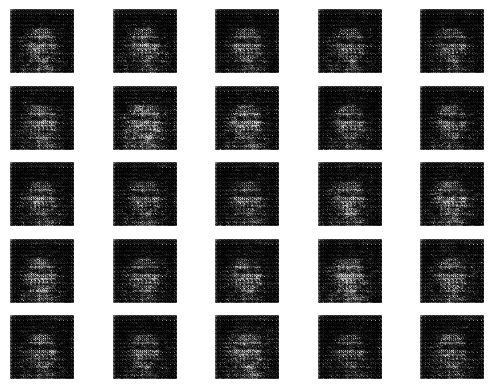

In [12]:
# Generar imágenes para mostrar
noise = np.random.normal(0, 1, (25, tamanio_codificacion))
gen_imgs = generador.predict(noise)

# Escalar imágenes a [0, 1]
gen_imgs = 0.5 * gen_imgs + 0.5

fig, axs = plt.subplots(5, 5)
for i in range(5):
    for j in range(5):
        axs[i, j].imshow(gen_imgs[i * 5 + j, :, :, 0], cmap='gray')
        axs[i, j].axis('off')
plt.show()

--------
### **Reflexión**

Reflexione sobre lo aprendido en la sesión teórica y cómo se aplicó en el laboratorio. Algunos 
puntos que podrían considerar en su reflexión incluyen:

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?


2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?


3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?

4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?


5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la  experiencia práctica?